In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Object Detection

The goal is to detect an object (a hiragana character) within an image of size 1x300x300 (contains mixing of many Kanji characters).

### Visualize dataset

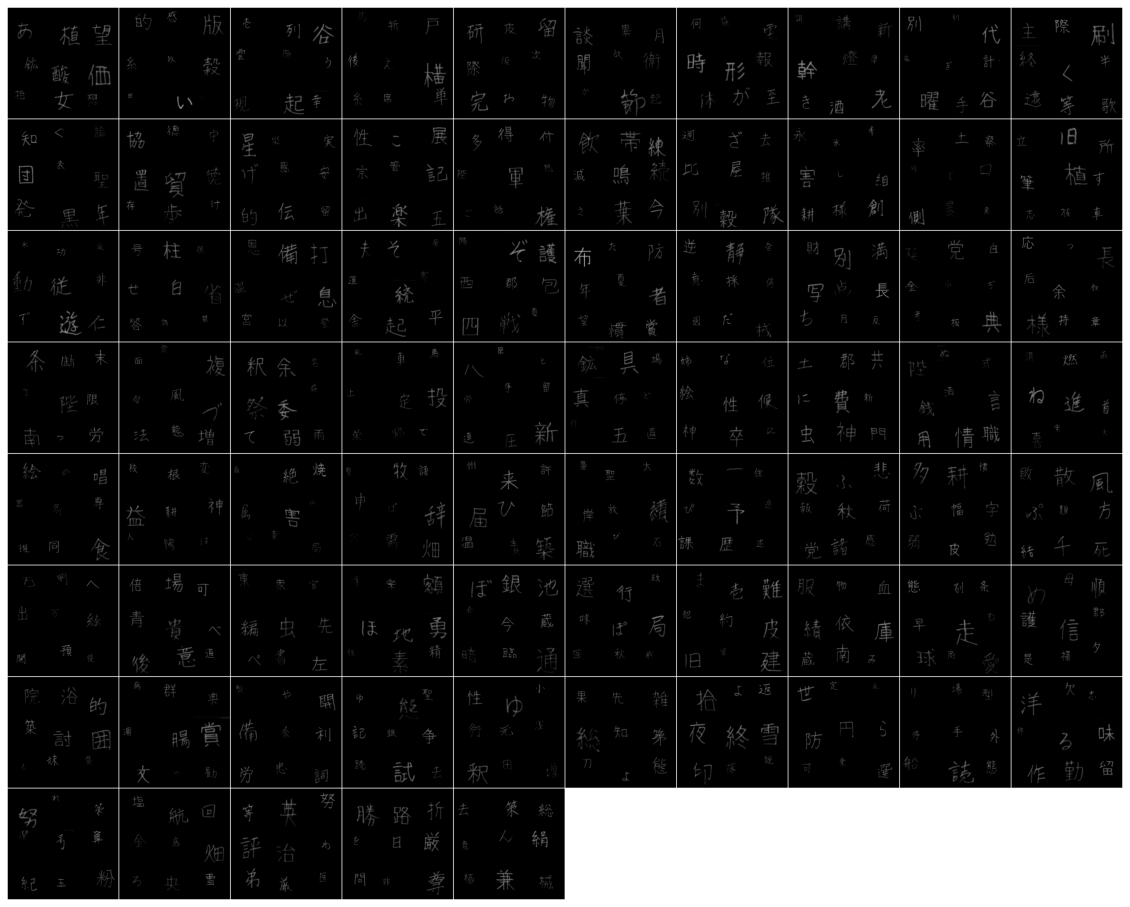

In [2]:
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import cv2
from tqdm.auto import tqdm
import PIL
from PIL import Image

SKIP=10
assert 160 % SKIP == 0

#DATA = np.load('drive/My Drive/Colab Notebooks/ETL8G_300x300.npz')
DATA = np.load('/content/drive/My Drive/分野別演習2020/#05 DNN/ETL8G_300x300.npz')

# 300x300 images, 75 hiragana classes, 160 images per class
IMG = DATA['img']

# the label [0:74] of each image.
LABEL = DATA['label'].astype(np.int64)

# the hiragana in each image
MOJI = DATA['moji']

# the bounding box (X, Y, W, H) of the hiragana in each image (X and Y defines the top-left corner of the box in the image)
BBOX = DATA['bbox']

if SKIP > 1:
    IMG = IMG[::SKIP,:,:]
    LABEL = LABEL[::SKIP]
    MOJI = MOJI[::SKIP]
    BBOX = BBOX[::SKIP]

# show thumbnails
plt.figure(figsize=(20.0, 20.0))
grid = torchvision.utils.make_grid(torch.from_numpy(IMG[::160//SKIP,None,:,:].astype(np.float) / 255), nrow=10, pad_value=1)
plt.imshow(grid.clamp(0, 1).permute(1, 2, 0).expand(-1, -1, 3).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()



In [13]:
def show_image_bbox(ax, gray_img, bbox, pred_bbox=None, pred_moji=None, mode=None):
    if np.max(gray_img) <= 1.0:
        gray_img = gray_img * 255
    bgr = cv2.cvtColor(gray_img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    bgr = cv2.rectangle(bgr, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), (255, 0, 0), 3)
    if mode: # if mode=None -> only plot bbox
        bgr = cv2.rectangle(bgr, (pred_bbox[0], pred_bbox[1]), (pred_bbox[0]+bbox[2], pred_bbox[1]+pred_bbox[3]), (0, 255, 0), 3)
        #bgr = cv2.putText(bgr, pred_moji, (pred_bbox[0], pred_bbox[1]), cv2.FONT_HERSHEY_COMPLEX,0.5,(0,0,0),1)
    ax.imshow(bgr)

<class 'numpy.ndarray'> (300, 300) uint8
[ 28 110  62  62]


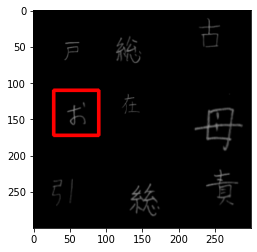

In [ ]:
# show an image with bbox
idx = np.random.randint(0,1000)
fig, ax = plt.subplots(1,1)
img = DATA['img'][idx, :,:]
bbox = DATA['bbox'][idx,:]
print(type(img), img.shape, img.dtype)
show_image_bbox(ax, img, bbox)
fig.show()

print(bbox)

# Object detection with YOLO algorithm.

I built my YOLO model based on this lecture [source](https://www.coursera.org/lecture/convolutional-neural-networks/object-localization-nEeJM) (Andrew Ng) and this article [source](https://leonardoaraujosantos.gitbook.io/artificial-inteligence/machine_learning/deep_learning/single-shot-detectors/yolo).

### Data processing

Resizing the images of size 1x300x300 into 1x320x320 by padding each size of the images with 10 pixels. 

The resized images can be seen to be divided into 5x5 grids, each grid is of size 64x64. The object (hiragana moji) is assigned to the grid that contains the centroid of the bbox. The other grids are seen as containing no object.

The bboxes are then translated and rescaled accordingly, so that x,y is the centroid of the bbox.  The values of x,y are computed by assumming the top left corner of the grid containing the centroid as (0,0). The values of x, y are scaled to (0,1) by divided by the size of the grid. The width w and height h are scaled by divided by the size of the grid. Hence, it is possible that w, h > 1. 

Details are in Andrew Ng's [Bounding Box Prediction](https://www.coursera.org/lecture/convolutional-neural-networks/bounding-box-predictions-9EcTO)

In [3]:
W_size = 300 + 20 # padded 20 pixels
H_size = 300 + 20
GRID_SIZE = 64

def pad_bbox(bbox):
  if bbox.ndim > 1:
      bbox[:,:2] += 10
  else:
      bbox[:2] += 10
  return bbox # translate bx, by with 10 pixels

# scale bbox
def scale_bbox(bbox):
  bbox = np.array(bbox)
  bbox = bbox.astype(np.float32)
  # move bx, by to center
  if bbox.ndim == 1: 
      bbox = bbox.reshape(1,-1)
  bbox[:,:2] += bbox[:,2:]/2
  # scale
  scale_pos, grid_idx = np.modf(bbox[:,:2]/GRID_SIZE)
  bbox[:,:2] = scale_pos
  bbox[:,2:] /= GRID_SIZE

  return grid_idx, bbox

# rescale bbox
def rescale_bbox(grid_idx, bbox):
  #bbox = np.array(bbox)
  if bbox.ndim == 1: 
      bbox = bbox.reshape(1,-1)
      
  # rescale
  bbox[:,:2] = GRID_SIZE*(grid_idx + bbox[:,:2])
  bbox[:,2:] = GRID_SIZE*bbox[:,2:]
  
  # move bx, by to top left
  bbox[:,:2] -= bbox[:,2:]/2
  
  try:
      bbox = bbox.astype(np.int32)
  except:
      bbox = bbox.type(torch.LongTensor)

  return bbox

### Dataset and dataloader

The groundtruth label for each grid will be a vector of size (1+4)x1 + 75 = 80. 
* The first values is for confidence score, which determine if there exists a object (hiragana moji) in the grid or not. This value is 0 or 1. 
* The next 4 values are for bbox x, y, w, h. The values of x,y is between 0,1. The values of w, h can be greater than 1.
* The next 75 values are hiragana class probability for the moji if it exists in the grid. 

If the confidence score is 0, which indicates there is no hiragana moji in the grid, the other 79 values for bbox and class probability in the groundtruth label are dont care, and can be set to any values. I set them to be 0. 

Each image has 5x5 grid, therefore the groudtruth label for each image is a tensor of size 5x5x80.

In [4]:
from sklearn.model_selection import train_test_split

IMG = DATA['img']
LABEL = DATA['label']
MOJI = DATA['moji']
BBOX = DATA['bbox']

print('BBOX origin ', BBOX[0])
BBOX = pad_bbox(BBOX)  # padd bx, by with 10 pixels each
print('BBOX padded ', BBOX[0])
BBOX_grid, BBOX = scale_bbox(BBOX) # scale bbox to (0,1)
BBOX_grid = BBOX_grid.astype(np.uint8)
print('BBOX grid: ', BBOX_grid[0])

I_train, I_test, L_train, L_test, M_train, M_test, BB_train, BB_test, Gr_train, Gr_test = train_test_split(IMG, LABEL, MOJI, BBOX, BBOX_grid)

print('IMG  : ', I_train.shape, I_test.shape)
print('LABEL: ', L_train.shape, L_test.shape)
print('MOJI : ', M_train.shape, M_test.shape)
print('BBOX : ', BB_train.shape, BB_test.shape)


class CustomTensorDataset(torch.utils.data.Dataset):
    """
    TensorDataset with support of transforms.
    https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset
    """
    def __init__(self, tensors, transform=None):
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        img = self.tensors[0][index, :, :]
        if self.transform:
            img = self.transform(PIL.Image.fromarray(img))
            
        label = self.tensors[1][index]
        bbox = self.tensors[2][index, :]
        grid = self.tensors[3][index, :] # x, y coordinates

        grid_label = torch.zeros((5, 5, 80)) # 5 x 5 x 80

        grid_label[grid[1], grid[0], 0] = 1. # obj is in grid
        grid_label[grid[1], grid[0], 1:5] = torch.from_numpy(bbox)
        grid_label[grid[1], grid[0], 5+label] = 1. # obj is in which class


        return img, grid_label, grid, label  # outputing grid (grid location of the hiragana moji and label just for checking if the dataset works correctly)

    def __len__(self):
        return self.tensors[0].shape[0]

# add more transform for data augmentation
transform = torchvision.transforms.Compose([
    torchvision.transforms.Pad(padding=10, fill=0), # Adding Pad to transfrom to pad around each image with 10 pixels.
    torchvision.transforms.ToTensor(),
])

# data loader
def get_dataloader(dataset, batch_size=128, shuffle=True, device=None):
    uses_cuda = False if device is None else device.type == 'cuda'
    return torch.utils.data.DataLoader(
        dataset,
        batch_size,
        shuffle,
        num_workers = 4 if uses_cuda else 0,
        pin_memory = uses_cuda
    )

BBOX origin  [ 0 13 94 94]
BBOX padded  [10 23 94 94]
BBOX grid:  [0 1]
IMG  :  (9000, 300, 300) (3000, 300, 300)
LABEL:  (9000,) (3000,)
MOJI :  (9000,) (3000,)
BBOX :  (9000, 4) (3000, 4)


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

train_loader = get_dataloader(CustomTensorDataset((I_train, L_train, BB_train, Gr_train), transform), batch_size=32, device=device)
test_loader = get_dataloader(CustomTensorDataset((I_test, L_test, BB_test, Gr_test), transform), batch_size=32, device=device)

cuda


### TinyYOLO Model

This model is partly based on the [TinyYOLO model](https://leonardoaraujosantos.gitbook.io/artificial-inteligence/machine_learning/deep_learning/single-shot-detectors/yolo).

In [6]:
class TinyYOLO(nn.Module):
    def __init__(self):
        super(TinyYOLO, self).__init__()
        
        self.act = nn.LeakyReLU(0.2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop = nn.Dropout2d(p=0.5)
        
        self.sig = nn.Sigmoid()
        #self.soft = nn.Softmax(dim=-1) # softmax along last channel

        self.ConvBlock = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), nn.BatchNorm2d(32), self.act, 
            nn.Conv2d(32, 32, 3, 1, 1), nn.BatchNorm2d(32), self.act, 
            self.pool,
            nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), self.act,
            nn.Conv2d(64, 64, 3, 1, 1), nn.BatchNorm2d(64), self.act,
            self.pool,
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), self.act,
            nn.Conv2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128), self.act,
            self.pool,
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), self.act,
            nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256), self.act,
            self.pool,
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), self.act,
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), self.act,
            self.pool,
            nn.Conv2d(512, 1024, 3, 1, 1), nn.BatchNorm2d(1024), self.act,
            nn.Conv2d(1024, 1024, 3, 1, 1), nn.BatchNorm2d(1024), self.act,
            self.pool,
        )

        self.FC_as_Conv = nn.Sequential(
            nn.Conv2d(1024, 4096, 1, 1, 0), self.act, self.drop, # it is okie to use Dropout here, I guess, after all it is just a FC layer
            nn.Conv2d(4096, 4096, 1, 1, 0), self.act, self.drop,
            nn.Conv2d(4096, 80, 1, 1, 0),  # 80 = 5 + 75
        )

    def forward(self, x):
        x = self.ConvBlock(x)
        x = self.FC_as_Conv(x)
        x = x.permute(0,2,3,1) # Batch x S x S x (5xB + C); B = 1, C = 75
        
        x1 = torch.sigmoid(x[:,:,:,0:3]) # confidence, bx, by -> (0,1)
        x2 = 5 * torch.sigmoid(x[:,:,:,3:5]) # width, height -> (0, 5) : 5 is due to image is divided into 5x5 grids
        x3 = x[:,:,:,5:]        

        return torch.cat((x1, x2, x3), dim=-1)

### Loss Layer

A variant of the original YOLO loss ia used.

Loss = 

$\lambda_{coord} \sum_{i=o}^{25}  1_{i}^{obj} [ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 + (\sqrt{w_i} - \sqrt{\hat{w}_i} )^2  + (\sqrt{h_i} - \sqrt{\hat{h}_i} )^2  ]  + 
\sum_{i}^{25} 1_{i}^{obj} (c_{i} - \hat{c}_i)^2 +
\lambda_{noobj}  \sum_{i}^{25} 1_{i}^{noobj} (c_{i} - \hat{c}_i)^2 + 
\sum_{i}^{25} 1_{i}^{obj} CrossEntropyLoss( p_i , \hat{p}_i )
$



In [7]:
def unravel_index(index, shape):
    out = []
    for dim in reversed(shape):
        out.append(index % dim)
        index = index // dim
    return tuple(reversed(out))

In [8]:
import torch.nn.functional as F

class Loss(nn.Module):
    def __init__(self, feature_size=5, num_bboxes=1, num_classes=75, lambda_coord=5.0, lambda_noobj=0.5):
        super(Loss, self).__init__()

        self.S = feature_size
        self.B = num_bboxes
        self.C = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    def compute_iou(self, grid1, grid2, box1, box2):
        """
        box1: (batch, 4) each cell has only one box
        box2: (batch, 4)
        return (batch,) iou of batch pairs of bbox
        """

        box1 = rescale_bbox(grid1.to(device), box1)
        box2 = rescale_bbox(grid2.to(device), box2)
        
        xy_min1 = box1[:,:2] - box1[:,2:]/2
        xy_max1 = box1[:,:2] + box1[:,2:]/2
        xy_min2 = box2[:,:2] - box2[:,2:]/2
        xy_max2 = box2[:,:2] + box2[:,2:]/2

        # the following refers to https://leonardoaraujosantos.gitbook.io/artificial-inteligence/machine_learning/deep_learning/single-shot-detectors/yolo

        # get areas
        edges1 = xy_max1 - xy_min1
        areas_1 =  (edges1[:,0] * edges1[:,1]).type(torch.FloatTensor)
        
        edges2 = xy_max2 - xy_min2
        areas_2 = (edges2[:,0] * edges2[:,1]).type(torch.FloatTensor)

        # determine the (x, y)-coordinates of the intersection rectangle
        _xy_min = torch.max(xy_min1, xy_min2)
        _xy_max = torch.min(xy_max1, xy_max2)
        _edges = torch.max(_xy_max - _xy_min, torch.zeros_like(_xy_min))

        # compute the area of intersection rectangle
        _areas = (_edges[:,0] * _edges[:,1]).type(torch.FloatTensor)

        ious = _areas / torch.max((areas_1 + areas_2 - _areas), 1e-10*torch.ones_like(_areas))

        correct_thresh = 0.5

        correct_detection = torch.sum(ious > correct_thresh)

        mean_iou = torch.mean(ious)

        return mean_iou, correct_detection

    def forward(self, pred_tensor, tar_tensor, verbose=False):
        """
        pred_tensor: batch x 5 x 5 x 80 (80 = 5x1 + 75) [conf, x, y, w, h] + [class prob]
        target_tensor: batch x 5 x 5 x 80
        """
        batch = pred_tensor.shape[0]

        obj_mask = tar_tensor[:, :, :, 0] > 0  # batch x S x S
        obj_mask = obj_mask.unsqueeze(-1).expand_as(tar_tensor) # batch x S x S x N
        noobj_mask = tar_tensor[:, :, :, 0] == 0 # batch x S x S
        
        # confidence loss on noobj cells
        pred_conf = pred_tensor[:, :, :, 0] # batch x S x S
        tar_conf = tar_tensor[:, :, :, 0] # batch x S x S
        
        loss_noobj = F.mse_loss(pred_conf[noobj_mask], tar_conf[noobj_mask]) #, reduction='sum')


        # coordinate x,y loss
        pred_xy = pred_tensor[:, :, :, 1:3] # batch x S x S x 2
        tar_xy = tar_tensor[:, :, :, 1:3]
        mask_xy = obj_mask[:, :, :, 1:3]
        loss_xy = F.mse_loss(pred_xy[mask_xy], tar_xy[mask_xy]) #, reduction='sum')

        
        # width, heigh loss
        pred_wh = pred_tensor[:, :, :, 3:5]  # batch x S x S x 2
        tar_wh = tar_tensor[:, :, :, 3:5]
        mask_wh = obj_mask[:, :, :, 3:5]
        # apply root square to w, h and compute loss
        loss_wh = F.mse_loss(torch.sqrt(pred_wh[mask_wh]), torch.sqrt(tar_wh[mask_wh])) #, reduction='sum')
        

        # compute iou
        pred_bbox = pred_tensor[:, :, :, 1:5] # batch x S x S x 5 [conf, x, y, w, h]
        tar_bbox = tar_tensor[:, :, :, 1:5]
        mask_bbox = obj_mask[:, :, :, 1:5]
        
        pred_bbox = pred_bbox[mask_bbox].view(-1, 4) # batch x 5
        tar_bbox = tar_bbox[mask_bbox].view(-1, 4)

        # tar_grid
        tar_grid = torch.zeros(batch, 2).type(torch.LongTensor)
        tar_grid_indices = torch.nonzero(mask_bbox[:,:,:,0])

        tar_grid[:,0] = tar_grid_indices[:,2] # i,j to weight, height coord
        tar_grid[:,1] = tar_grid_indices[:,1]
        
        # pred_grid
        pred_grid = torch.zeros(batch, 2).type(torch.LongTensor)
        pred_grid_indices = unravel_index(torch.argmax(pred_conf.reshape(batch, -1), dim=-1), (5,5))
        pred_grid[:,0] = pred_grid_indices[1]
        pred_grid[:,1] = pred_grid_indices[0]
        
        mean_iou, correct_detection = self.compute_iou(pred_grid, tar_grid, pred_bbox, tar_bbox)

        
        # confidence loss on obj cells
        # simply square loss of pred_conf and tar_conf at cells with obj
        loss_obj = F.mse_loss(pred_conf[obj_mask[:,:,:,0]], tar_conf[obj_mask[:,:,:,0]])


        # loss on classification only on cells with obj
        pred_class = pred_tensor[:, :, :, 5:] # batch x S x S x 75
        tar_class = tar_tensor[:, :, :, 5:]
        mask_class = obj_mask[:, :, :, 5:]

        pred_prob = pred_class[mask_class].reshape(batch, 75)
        tar_label = torch.argmax(tar_class[mask_class].reshape(batch, 75), dim=1)
        
        loss_class = F.cross_entropy(pred_prob, tar_label)
        
        
        # total loss
        loss = self.lambda_coord * (loss_xy + loss_wh) + loss_obj + self.lambda_noobj * loss_noobj + loss_class
        
        return loss, mean_iou, correct_detection


### Training

In [15]:
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

OUTNAME = '/content/drive/My Drive/分野別演習2020/#05 DNN/Label_Working_TinyYOLO_crossentropy'

model = TinyYOLO().to(device)

print_freq = 10

init_lr = 0.001
base_lr = 0.01
momentum = 0.9
weight_decay = 5.0e-4

num_epochs = 100
batch_size = 32

optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, momentum=momentum, weight_decay=weight_decay)
criterion = Loss(lambda_coord=5, lambda_noobj=0.5) 


train_loader = get_dataloader(CustomTensorDataset((I_train, L_train, BB_train, Gr_train), transform), batch_size=batch_size, device=device)
test_loader = get_dataloader(CustomTensorDataset((I_test, L_test, BB_test, Gr_test), transform), batch_size=batch_size, device=device)


# Learning rate scheduling.
# The update_lr and get_lr functions are not mine, I refer them on the internet
def update_lr(optimizer, epoch, burnin_base, burnin_exp=4.0):
    if epoch == 0:
        lr = init_lr + (base_lr - init_lr) * math.pow(burnin_base, burnin_exp)
    elif epoch == 1:
        lr = base_lr
    elif epoch == 75:
        lr = 0.001
    elif epoch == 105:
        lr = 0.0001
    else:
        return

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


# Training
train_losses = []

train_grid_accuracies = []
train_ious = []
train_box_accuracies = []
train_label_accuracies = []

test_losses = []

test_grid_accuracies = []
test_ious = []
test_box_accuracies = []
test_label_accuracies = []

start_epoch = -1

# Loading model if existed
try:
    checkpoint = torch.load(f'{OUTNAME}.tar')
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print('Successfully LOAD existing state_dict to model and optimizer ...')

    train_losses = checkpoint['train_losses']
    train_grid_accuracies = checkpoint['train_grid_accuracies']
    train_ious = checkpoint['train_ious']
    train_box_accuracies = checkpoint['train_box_accuracies']
    train_label_accuracies = checkpoint['train_label_accuracies']
    print('\tLoaded train losses, train accuracies ...')

    test_losses = checkpoint['test_losses']
    test_grid_accuracies = checkpoint['test_grid_accuracies']
    test_ious = checkpoint['test_ious']
    test_box_accuracies = checkpoint['test_box_accuracies']
    test_label_accuracies = checkpoint['test_label_accuracies']
    print('\tLoaded test losses, test accuracies ...')

    start_epoch = checkpoint['epoch']
    print('The model has been trained for %s epochs' %(start_epoch+1))
    
except Exception:
    print('No existing model or Error while loading model, train from scratch ...')


for epoch in range(1 + start_epoch, 1 + start_epoch + num_epochs):
    print('\n')
    print('Starting epoch {} / {}'.format(epoch, num_epochs))

    model.train()

    total_loss = 0.0
    total_ious = 0.0
    total_box_accuracy = 0
    total_label_accuracy = 0.0
    total_grid_accuracy = 0.0

    total_batch = 0

    bar = tqdm(train_loader, desc='Train Epoch: %s' %epoch, unit='batches')
    for i, (img, grid_label, _, _) in enumerate(bar):
        # udpate lr
        update_lr(optimizer, epoch, float(i) / float(len(train_loader) - 1))
        lr = get_lr(optimizer)

        # loss
        batch = img.size(0)

        img, tar_tensor = img.to(device), grid_label.to(device)
        
        pred_tensor = model(img)
        loss, mean_iou, correct_detection = criterion(pred_tensor, tar_tensor, verbose=(i % print_freq == 0))

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss
        total_loss += loss.item() * batch
        # ious
        total_ious += mean_iou.item() * batch
        # box accuracy
        total_box_accuracy += correct_detection.item()
        
        # grid accuracy
        pred_grid = pred_tensor[:,:,:,0]
        pred_grid = pred_grid.view(batch, -1)
        grid_indices = torch.argmax(pred_grid, dim=1)
        grid_indices = unravel_index(grid_indices, (5,5))
        
        batch_idx = torch.LongTensor(np.arange(batch))
        pred = tar_tensor[:,:,:,0][(batch_idx, grid_indices[0], grid_indices[1])]

        total_grid_accuracy += torch.sum(pred).item()

        # label accuracy (classification)
        class_prob = pred_tensor[:,:,:,5:][(batch_idx, grid_indices[0], grid_indices[1])]
        class_idx = torch.argmax(class_prob, dim=1)
        class_pred = tar_tensor[:,:,:,5:][(batch_idx, grid_indices[0], grid_indices[1], class_idx)]
        
        total_label_accuracy += torch.sum(class_pred).item()


        # total batch
        total_batch += batch

        bar.set_postfix(total_loss_avg = total_loss/total_batch, 
                        mean_iou = total_ious/total_batch, 
                        box_accuracy = total_box_accuracy / total_batch, 
                        grid_accuracy = total_grid_accuracy / total_batch, 
                        label_accuracy = total_label_accuracy / total_batch, ) 
                        #LEARNING_RATE = lr,)

    train_losses.append(total_loss/total_batch)
    train_ious.append(total_ious/total_batch)
    train_box_accuracies.append(total_box_accuracy/total_batch)
    train_grid_accuracies.append(total_grid_accuracy/total_batch)
    train_label_accuracies.append(total_label_accuracy/total_batch)


    # Inference mode
    model.eval()

    total_loss = 0.0
    total_ious = 0.0
    total_box_accuracy = 0
    total_label_accuracy = 0.0
    total_grid_accuracy = 0.0

    total_batch = 0

    with torch.no_grad():
        bar = tqdm(test_loader, desc='Test Epoch: %s' %epoch, unit='batches')
        for i, (img, grid_label, _, _) in enumerate(bar):
            
            # loss
            batch = img.size(0)

            img, tar_tensor = img.to(device), grid_label.to(device)
            
            pred_tensor = model(img)
            loss, mean_iou, correct_detection = criterion(pred_tensor, tar_tensor, verbose=(i % print_freq == 0))            

            # loss
            total_loss += loss.item() * batch
            # ious
            total_ious += mean_iou.item() * batch
            # box accuracy
            total_box_accuracy += correct_detection.item()
            
            # grid accuracy
            pred_grid = pred_tensor[:,:,:,0]
            pred_grid = pred_grid.view(batch, -1)
            grid_indices = torch.argmax(pred_grid, dim=1)
            grid_indices = unravel_index(grid_indices, (5,5))
            
            batch_idx = torch.LongTensor(np.arange(batch))
            pred = tar_tensor[:,:,:,0][(batch_idx, grid_indices[0], grid_indices[1])]

            total_grid_accuracy += torch.sum(pred).item()

            # label accuracy (classification)
            class_prob = pred_tensor[:,:,:,5:][(batch_idx, grid_indices[0], grid_indices[1])]
            class_idx = torch.argmax(class_prob, dim=1)
            class_pred = tar_tensor[:,:,:,5:][(batch_idx, grid_indices[0], grid_indices[1], class_idx)]
            
            total_label_accuracy += torch.sum(class_pred).item()


            # total batch
            total_batch += batch

            bar.set_postfix(total_loss_avg = total_loss/total_batch, 
                            mean_iou = total_ious/total_batch, 
                            box_accuracy = total_box_accuracy / total_batch, 
                            grid_accuracy = total_grid_accuracy / total_batch, 
                            label_accuracy = total_label_accuracy / total_batch, )

        test_losses.append(total_loss/total_batch)
        test_ious.append(total_ious/total_batch)
        test_box_accuracies.append(total_box_accuracy/total_batch)
        test_grid_accuracies.append(total_grid_accuracy/total_batch)
        test_label_accuracies.append(total_label_accuracy/total_batch)


        # save the model if box_accuracy is better than before
        if len(test_box_accuracies) > 1 and test_box_accuracies[-1] > max(test_box_accuracies[:-1]):
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,

                'train_losses': train_losses,
                'train_ious': train_ious,
                'train_box_accuracies': train_box_accuracies,
                'train_grid_accuracies': train_grid_accuracies,
                'train_label_accuracies': train_label_accuracies,

                'test_losses': test_losses,
                'test_ious': test_ious,
                'test_box_accuracies': test_box_accuracies,
                'test_grid_accuracies': test_grid_accuracies,
                'test_label_accuracies': test_label_accuracies,

            }

            torch.save(checkpoint,f'{OUTNAME}_best_bbox.tar' )
            print('Saved best box_accuracy model at epoch %s' %epoch)


        # save the model after several epochs
        if epoch % 5 == 0:
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,

                'train_losses': train_losses,
                'train_ious': train_ious,
                'train_box_accuracies': train_box_accuracies,
                'train_grid_accuracies': train_grid_accuracies,
                'train_label_accuracies': train_label_accuracies,

                'test_losses': test_losses,
                'test_ious': test_ious,
                'test_box_accuracies': test_box_accuracies,
                'test_grid_accuracies': test_grid_accuracies,
                'test_label_accuracies': test_label_accuracies,

            }

            torch.save(checkpoint,f'{OUTNAME}.tar' )
            print('Saved model at epoch %s' %epoch)            




cuda
Successfully LOAD existing state_dict to model and optimizer ...
	Loaded train losses, train accuracies ...
	Loaded test losses, test accuracies ...
The model has been trained for 116 epochs


Starting epoch 116 / 100


KeyboardInterrupt: ignored

### Training losses and accuracies

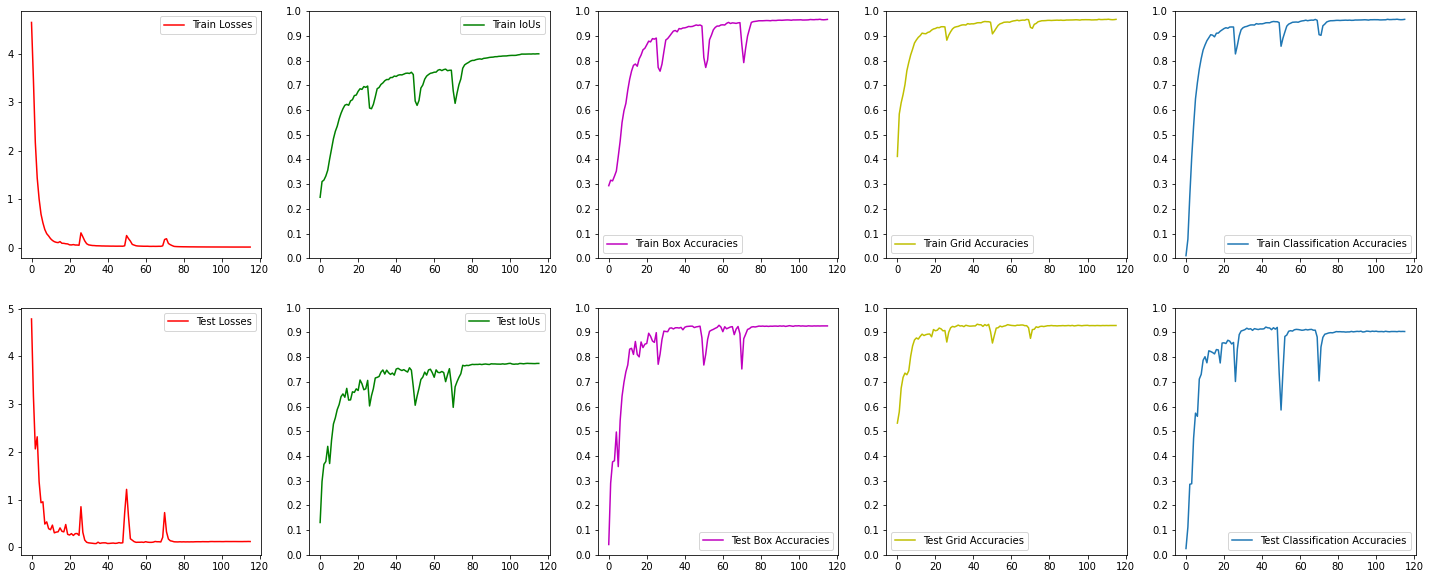

In [16]:
fig, ax = plt.subplots(2, 5)
fig.set_figheight(10)
fig.set_figwidth(25)

ax[0,0].plot(train_losses, 'r', label='Train Losses')
ax[0,1].plot(train_ious, 'g', label='Train IoUs')
ax[0,2].plot(train_box_accuracies, 'm', label='Train Box Accuracies')
ax[0,3].plot(train_grid_accuracies, 'y', label='Train Grid Accuracies')
ax[0,4].plot(train_label_accuracies, label='Train Classification Accuracies')

ax[1,0].plot(test_losses, 'r', label='Test Losses')
ax[1,1].plot(test_ious, 'g', label='Test IoUs')
ax[1,2].plot(test_box_accuracies, 'm', label='Test Box Accuracies')
ax[1,3].plot(test_grid_accuracies, 'y', label='Test Grid Accuracies')
ax[1,4].plot(test_label_accuracies, label='Test Classification Accuracies')

for i in range(1,5):
    ax[0,i].set_ylim(0,1)
    ax[1,i].set_ylim(0,1)

    ax[0,i].set_yticks([i/10 for i in range(0, 11)])
    ax[1,i].set_yticks([i/10 for i in range(0, 11)])

for i in range(5):
    ax[0,i].legend()
    ax[1,i].legend()


### Testing accuracies

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

OUTNAME = '/content/drive/My Drive/分野別演習2020/#05 DNN/Label_Working_TinyYOLO_crossentropy_best_bbox'

model = TinyYOLO().to(device)

batch_size = 32

test_loader = get_dataloader(CustomTensorDataset((I_test, L_test, BB_test, Gr_test), transform), batch_size=batch_size, device=device)

criterion = Loss(lambda_coord=5, lambda_noobj=0.5)

try:
    checkpoint = torch.load(f'{OUTNAME}.tar')
    model.load_state_dict(checkpoint['model'])
    print('Successfully LOAD existing state_dict to model ...')

    start_epoch = checkpoint['epoch']
    print('The model has been trained for %s epochs' %(start_epoch+1))
    
except Exception as e:
    raise e

# Inference mode
model.eval()

total_loss = 0.0
total_ious = 0.0
total_box_accuracy = 0
total_label_accuracy = 0.0
total_grid_accuracy = 0.0

total_batch = 0

with torch.no_grad():
    bar = tqdm(test_loader, desc='Evaluation on Test data', unit='batches')
    for i, (img, grid_label, _, _) in enumerate(bar):
        
        # loss
        batch = img.size(0)

        img, tar_tensor = img.to(device), grid_label.to(device)
        
        pred_tensor = model(img)
        loss, mean_iou, correct_detection = criterion(pred_tensor, tar_tensor)            

        # loss
        total_loss += loss.item() * batch
        # ious
        total_ious += mean_iou.item() * batch
        # box accuracy
        total_box_accuracy += correct_detection.item()
        
        # grid accuracy
        pred_grid = pred_tensor[:,:,:,0]
        pred_grid = pred_grid.view(batch, -1)
        grid_indices = torch.argmax(pred_grid, dim=1)
        grid_indices = unravel_index(grid_indices, (5,5))
        
        batch_idx = torch.LongTensor(np.arange(batch))
        pred = tar_tensor[:,:,:,0][(batch_idx, grid_indices[0], grid_indices[1])]

        total_grid_accuracy += torch.sum(pred).item()

        # label accuracy (classification)
        class_prob = pred_tensor[:,:,:,5:][(batch_idx, grid_indices[0], grid_indices[1])]
        class_idx = torch.argmax(class_prob, dim=1)
        class_pred = tar_tensor[:,:,:,5:][(batch_idx, grid_indices[0], grid_indices[1], class_idx)]
        
        total_label_accuracy += torch.sum(class_pred).item()


        # total batch
        total_batch += batch

        bar.set_postfix(total_loss_avg = total_loss/total_batch, 
                        mean_iou = total_ious/total_batch, 
                        box_accuracy = total_box_accuracy / total_batch, 
                        grid_accuracy = total_grid_accuracy / total_batch, 
                        label_accuracy = total_label_accuracy / total_batch, )
        
    print('Mean IoU: %.4f' %(total_ious/total_batch))
    print('Box accuracy: %.4f' %(total_box_accuracy / total_batch))
    print('Grid accuracy: %.4f' %(total_grid_accuracy / total_batch))
    print('Label accuracy: %.4f' %(total_label_accuracy / total_batch))

cuda
Successfully LOAD existing state_dict to model ...
The model has been trained for 59 epochs



Mean IoU: 0.7988
Box accuracy: 0.9577
Grid accuracy: 0.9583
Label accuracy: 0.9533


### Visualize results

Pred label: 
 ['ざ' 'る' 'よ' 'み' 'せ' 'ぎ' 'す' 'げ' 'な' 'こ']
True label:
 ['ざ' 'る' 'よ' 'み' 'せ' 'ぎ' 'す' 'げ' 'な' 'こ']


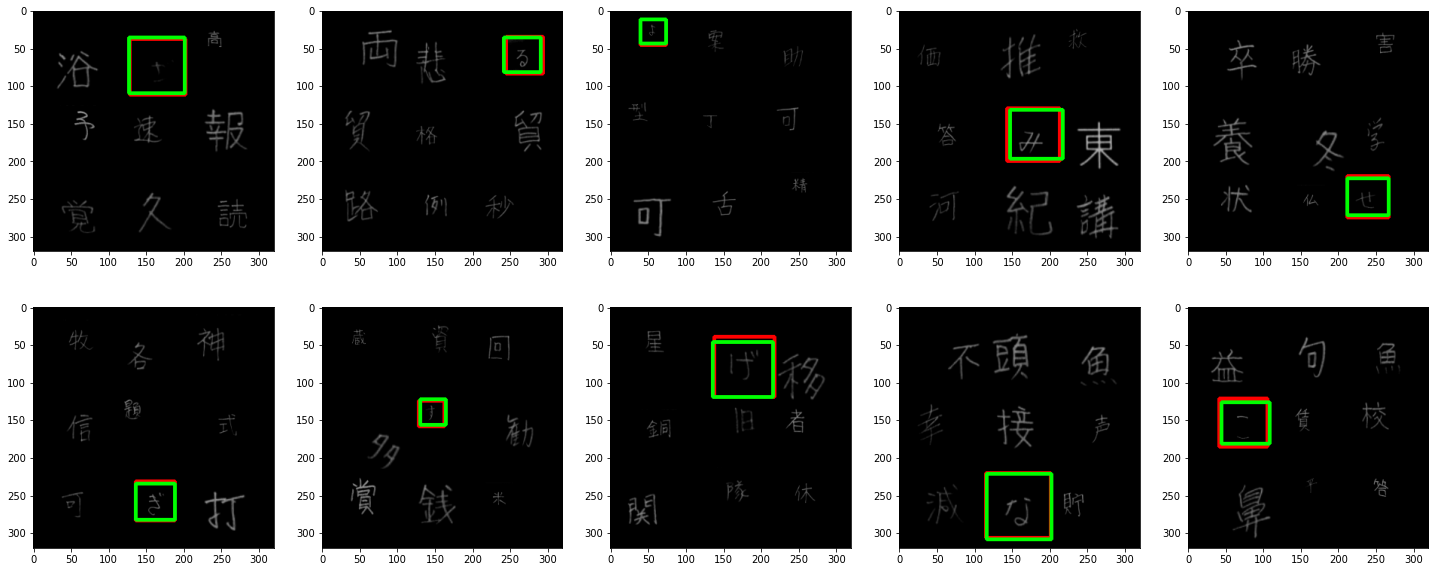

In [18]:
def label2moji(labels):
    """labels: array of label"""
    return MOJI[0::160][labels]

#device = torch.device('cpu')
#model_P.to(device)

with torch.no_grad(): # We do not need autograd for inference
    inputs, tar_tensor, grid_locas, labels = next(iter(test_loader))

    batch = inputs.shape[0]
    
    inputs = inputs.to(device) #, tar_tensor.to(device)
    pred_tensor = model(inputs)
    
    imgs = inputs
    imgs = imgs.to('cpu')
    imgs = np.array(imgs)#.astype(np.uint8)
    
    # pred bbox
    pred_grid = pred_tensor[:,:,:,0]
    pred_grid = pred_grid.view(batch, -1)
    grid_indices = torch.argmax(pred_grid, dim=1)
    grid_indices = unravel_index(grid_indices, (5,5))    

    batch_idx = torch.LongTensor(np.arange(batch))
    
    pred_bbox = pred_tensor[:,:,:,1:5][(batch_idx, grid_indices[0], grid_indices[1])]
    pred_bbox = pred_bbox.to('cpu')

    pred_grid = torch.zeros((grid_indices[0].shape[0], 2)).type(torch.LongTensor)
    pred_grid[:,0] = grid_indices[1]
    pred_grid[:,1] = grid_indices[0]

    pred_bbox = rescale_bbox(pred_grid, pred_bbox).numpy()

    # tar bbox
    grid_locas = grid_locas.type(torch.LongTensor)

    tar_bbox = tar_tensor[:,:,:,1:5][(batch_idx, grid_locas[:,1], grid_locas[:,0])]
    tar_bbox = rescale_bbox(grid_locas.to('cpu'), tar_bbox.to('cpu')).numpy()

    
    # labels
    pred_prob = pred_tensor[:,:,:,5:][(batch_idx, grid_indices[0], grid_indices[1])]
    pred_label = torch.argmax(pred_prob.reshape(batch, 75), dim =1).to('cpu')
    pred_moji = label2moji(pred_label)
    true_moji = label2moji(labels)
    

    fig, ax = plt.subplots(2,5)
    fig.set_figheight(10)
    fig.set_figwidth(25)
    for idx in range(10):
        if idx < 5:
            show_image_bbox(ax[0, idx], imgs[idx][0], tar_bbox[idx], pred_bbox[idx], pred_label[idx], mode='pred')
            #ax[0,idx].set_title('Prediction : %s' %pred_moji[idx])
        else:
            show_image_bbox(ax[1, idx-5], imgs[idx][0], tar_bbox[idx], pred_bbox[idx], pred_label[idx], mode='pred')
            #ax[1,idx-5].set_title('Prediction: %s' %pred_moji[idx])
    fig.show()


    #print('BBox Prediction: \n', pred_bbox[0:10])
    #print('BBox Ground truth: \n', tar_bbox[0:10])

    
    print('Pred label: \n', pred_moji[0:10])
    print('True label:\n', true_moji[0:10])